In [1]:
import os
import pandas as pd
#from sep_util import read_file
import utm
import numpy as np
import h5py
import time
import tqdm
import glob


# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 18, # fontsize for x and y labels (was 10)
    'axes.titlesize': 18,
    'font.size': 18,
    'legend.fontsize': 18,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'text.usetex':False,
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white'
}
matplotlib.rcParams.update(params)

In [2]:
# load the DAS channel location
DAS_info = np.genfromtxt('/kuafu/DASdata/DASinfo/DAS_ChannelLocation/DAS_Ridgecrest_ODH3.txt')

DAS_channel_num = DAS_info.shape[0]
DAS_index = DAS_info[:, 0].astype('int')
DAS_lon = DAS_info[:, 1]
DAS_lat = DAS_info[:, 2]

### First read the catalog, the catalog is from STP with command:

```bash
EVENT -mag 2.0 8.0 -lat 33.65 37.65 -lon -119.72 -115.72 -t0 2019/7/10,18:00:00 2021/6/5,18:00:00 -f Ridgecrest_das_catalog_M2_M8.txt
```

In [3]:
print(os.getcwd())
catalog_file =  '/home/yinjx/notebooks/strain_scaling/Ridgecrest_das_catalog_M2_M8.txt'
catalog = pd.read_csv(catalog_file, sep='\s+', header=None, skipfooter=1, engine='python')
catalog

/home/yinjx/notebooks/strain_scaling


,0,1,2,3,4,5,6,7,8,9
0,38521207,eq,l,"2019/07/10,18:00:01.250",35.7753,-117.6033,7.59,2.26,l,1.0
1,38521231,eq,l,"2019/07/10,18:01:27.840",35.6733,-117.5210,5.71,2.37,l,1.0
2,38521351,eq,l,"2019/07/10,18:11:09.650",35.7067,-117.5282,9.24,2.02,l,1.0
3,38521591,eq,l,"2019/07/10,18:30:10.250",35.6533,-117.5022,7.97,2.42,l,1.0
4,38521775,eq,l,"2019/07/10,18:44:42.310",35.6738,-117.5278,8.65,2.17,l,1.0
...,...,...,...,...,...,...,...,...,...,...
4409,39914032,eq,l,"2021/06/02,07:44:21.310",35.9512,-117.3327,3.37,2.16,l,1.0
4410,39915440,eq,l,"2021/06/03,04:48:33.690",34.3058,-116.9277,8.38,2.27,l,1.0
4411,39915912,eq,l,"2021/06/03,15:52:48.420",33.9922,-117.0828,16.10,2.13,l,1.0
4412,39916960,eq,l,"2021/06/04,12:18:09.310",33.9017,-116.1048,9.01,2.49,l,1.0


### Load the picked peak ampliutde

In [4]:
# Load the peak amplitude results
import pandas as pd
import numpy as np

results_output_dir = '/home/yinjx/kuafu/Ridgecrest/Ridgecrest_strain_rate_scaling/peak_ampliutde_scaling_results_M3+_v2'

# directory to store the fitted results
regression_results_dir = results_output_dir + '/regression_results_smf'
if not os.path.exists(regression_results_dir):
    os.mkdir(regression_results_dir)

In [5]:
das_pick_file_name = results_output_dir + '/peak_amplitude_M3+.csv'
peak_amplitude_df = pd.read_csv(das_pick_file_name)

peak_amplitude_df

,event_id,magnitude,distance_in_km,peak_P,peak_S,peak_P_strain,peak_S_strain,channel_id
0,38522647.0,4.17,13.325344,2845.676270,6852.172363,65830.260917,457527.605420,25.0
1,38522647.0,4.17,13.323814,2525.390625,5682.281250,58163.789094,486473.856774,26.0
2,38522647.0,4.17,13.322380,2594.920898,5590.161133,74316.607345,456189.352705,27.0
3,38522647.0,4.17,13.320950,2537.780762,6123.412598,63481.849276,462925.757152,28.0
4,38522647.0,4.17,13.319525,3586.303467,5624.999512,58752.156492,472509.723174,29.0
...,...,...,...,...,...,...,...,...
265645,39659271.0,3.59,54.072423,124.999992,214.843735,1717.730447,15170.860620,1245.0
265646,39659271.0,3.59,54.078379,134.765625,236.328110,1958.297253,13881.925274,1246.0
265647,39659271.0,3.59,54.084403,101.562492,247.070297,2413.973597,11384.488651,1247.0
265648,39659271.0,3.59,54.090361,100.463860,253.784164,3391.529309,12145.925357,1248.0


### Find event with the selected event ID using .isin()

In [6]:
event_id_selected = np.unique(peak_amplitude_df['event_id'])
catalog_select = catalog[catalog[0].isin(event_id_selected)]
num_events = catalog_select.shape[0]
catalog_select

,0,1,2,3,4,5,6,7,8,9
27,38522647,eq,l,"2019/07/10,20:09:51.950",35.6647,-117.5248,9.19,4.17,w,1.0
42,38523567,eq,l,"2019/07/10,21:40:58.420",35.5732,-117.5212,10.09,3.09,l,1.0
64,38524935,eq,l,"2019/07/10,23:48:43.270",35.6182,-117.4398,6.80,3.29,l,1.0
65,38525047,eq,l,"2019/07/10,23:58:59.200",35.6723,-117.4892,4.36,3.62,w,1.0
90,38526799,eq,l,"2019/07/11,02:35:22.450",35.9412,-117.7210,2.44,3.51,w,1.0
...,...,...,...,...,...,...,...,...,...,...
4279,39841832,eq,l,"2021/04/07,13:42:05.870",35.6097,-117.4105,8.97,3.64,l,1.0
4286,39843952,eq,l,"2021/04/08,20:51:15.140",35.6538,-117.5497,8.34,3.62,l,1.0
4292,39846664,eq,l,"2021/04/11,09:45:36.990",35.7847,-117.6030,6.61,3.13,l,1.0
4323,39634983,eq,l,"2021/04/29,17:12:19.480",35.6530,-117.4393,6.69,3.14,l,1.0


### Show a simple map for the DAS array and events

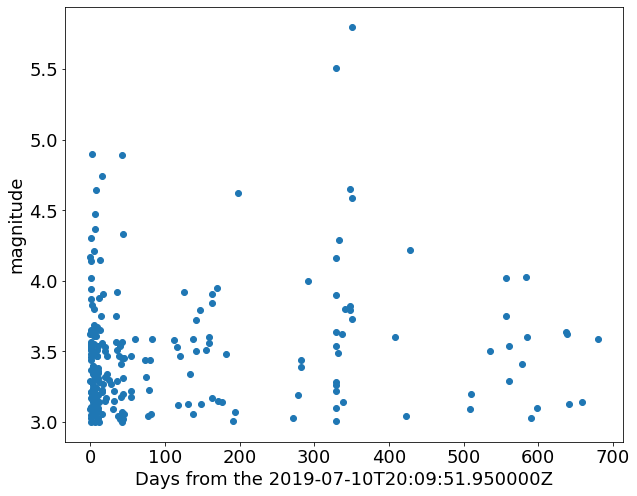

In [7]:
# Quickly look at the time variation of selected earthquakes
import obspy

time_list = [obspy.UTCDateTime(time) for time in catalog_select[3]]
time_span = np.array([time-time_list[0] for time in time_list])
time_span_days = time_span/3600/24

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(time_span_days, catalog_select[7], 'o')
ax.set_xlabel(f'Days from the {time_list[0]}')
ax.set_ylabel('magnitude')
plt.savefig(results_output_dir + '/time_variation_selected_earthquakes.png', bbox_inches='tight')

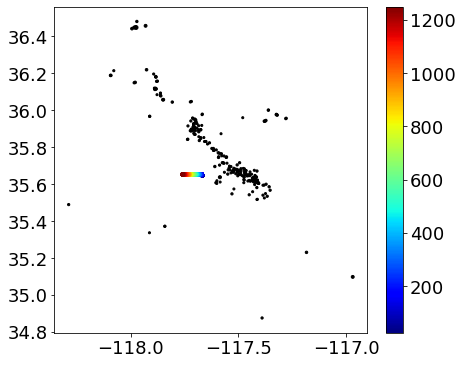

In [8]:
# Find the selected events
fig, ax = plt.subplots(figsize=(7, 6))
cmp = ax.scatter(DAS_lon, DAS_lat, s=10, c=DAS_index, cmap='jet')
ax.scatter(catalog_select[5], catalog_select[4], s=10**(catalog_select[7]/5), c='k')
fig.colorbar(cmp)
plt.savefig(results_output_dir + '/map_of_earthquakes_not_grouped.png', bbox_inches='tight')

### Flatten all the measured results.

In [9]:
def extract_flatten_data(peak_amplitude_df):
    peak_ampliutde_P_all_flatten = np.array(peak_amplitude_df['peak_P'])
    peak_ampliutde_S_all_flatten = np.array(peak_amplitude_df['peak_S'])
    distance_all_km_flatten = np.array(peak_amplitude_df['distance_in_km'])
    magnitude_all_flatten = np.array(peak_amplitude_df['magnitude'])
    event_id_all_flatten = np.array(peak_amplitude_df['event_id']).astype('int')
    
    return peak_ampliutde_P_all_flatten, peak_ampliutde_S_all_flatten, distance_all_km_flatten, magnitude_all_flatten, event_id_all_flatten

In [10]:
peak_ampliutde_P_all_flatten, peak_ampliutde_S_all_flatten, \
distance_all_km_flatten, magnitude_all_flatten, event_id_all_flatten = extract_flatten_data(peak_amplitude_df)

### Quickly check the data coverage and distributions

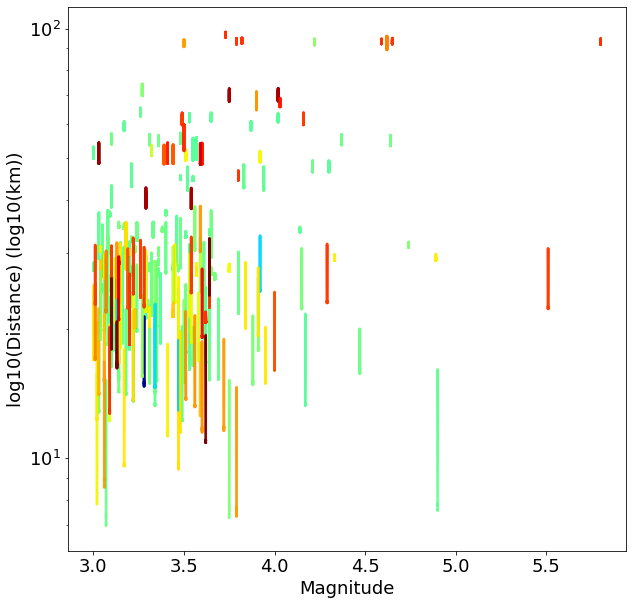

In [11]:
# Look at the data coverage in magnitude-distance space
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(peak_amplitude_df.magnitude, peak_amplitude_df.distance_in_km, 
           s=3, c=np.sqrt(peak_amplitude_df.event_id), marker='o', cmap='jet', alpha=0.1)

ax.set_yscale('log')
#ax[1].set_xscale('log')
ax.set_xlabel('Magnitude')
ax.set_ylabel('log10(Distance) (log10(km))')
plt.savefig(results_output_dir + '/magnitude_distance_distribution.png', bbox_inches='tight')

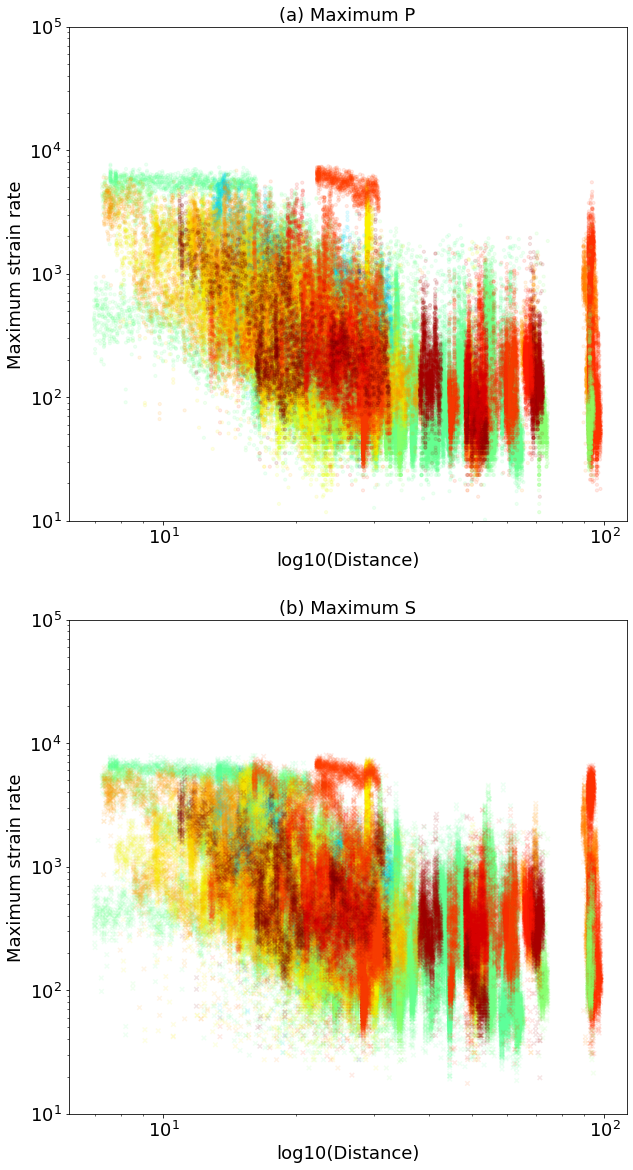

In [12]:
# Look at the rough variation of measured strain rate with distance
fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)
ax[0].scatter(peak_amplitude_df.distance_in_km, peak_amplitude_df.peak_P, 
              s=10, c=np.sqrt(peak_amplitude_df.event_id), marker='o', cmap='jet', alpha=0.1)
ax[1].scatter(peak_amplitude_df.distance_in_km, peak_amplitude_df.peak_S, 
              s=20, c=np.sqrt(peak_amplitude_df.event_id), marker='x', cmap='jet', alpha=0.1)

ax[1].set_yscale('log')
ax[1].set_xscale('log')


ax[0].set_ylabel('Maximum strain rate')
ax[0].set_xlabel('log10(Distance)')
ax[0].set_title('(a) Maximum P')
ax[0].xaxis.set_tick_params(which='both',labelbottom=True)
ax[1].set_title('(b) Maximum S')
ax[1].set_xlabel('log10(Distance)')
ax[1].set_ylabel('Maximum strain rate')
ax[1].set_ylim(10, 1e5)

plt.savefig(results_output_dir + '/peak_strain_rate_vs_distance.png', bbox_inches='tight')

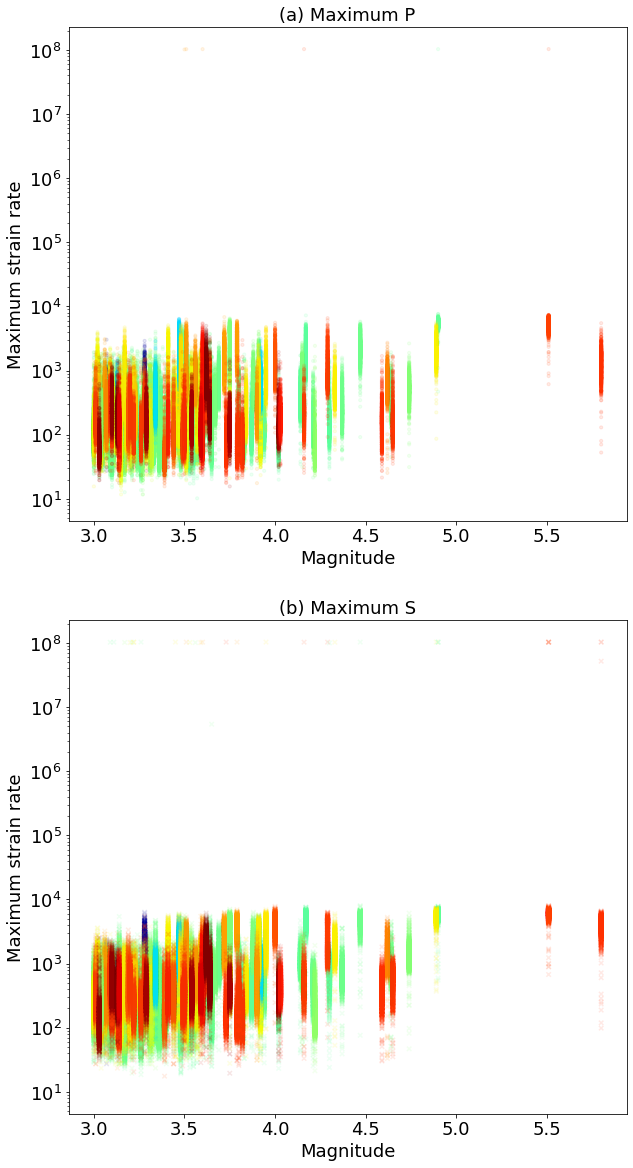

In [13]:
# Look at the rough variation of measured strain rate with magnitude

fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)
ax[0].scatter(peak_amplitude_df.magnitude, peak_amplitude_df.peak_P, 
              s=10, c=np.sqrt(peak_amplitude_df.event_id), marker='o', cmap='jet', alpha=0.1)
ax[1].scatter(peak_amplitude_df.magnitude, peak_amplitude_df.peak_S, 
              s=20, c=np.sqrt(peak_amplitude_df.event_id), marker='x', cmap='jet', alpha=0.1)

ax[1].set_yscale('log')

ax[0].set_ylabel('Maximum strain rate')
ax[0].set_xlabel('Magnitude')
ax[0].set_title('(a) Maximum P')
ax[0].xaxis.set_tick_params(which='both',labelbottom=True)
ax[1].set_title('(b) Maximum S')
ax[1].set_xlabel('Magnitude')
ax[1].set_ylabel('Maximum strain rate')
#ax[1].set_ylim(10, 1e5)

plt.savefig(results_output_dir + '/peak_strain_rate_vs_magnitude.png', bbox_inches='tight')

Median: 0.5072463768115942


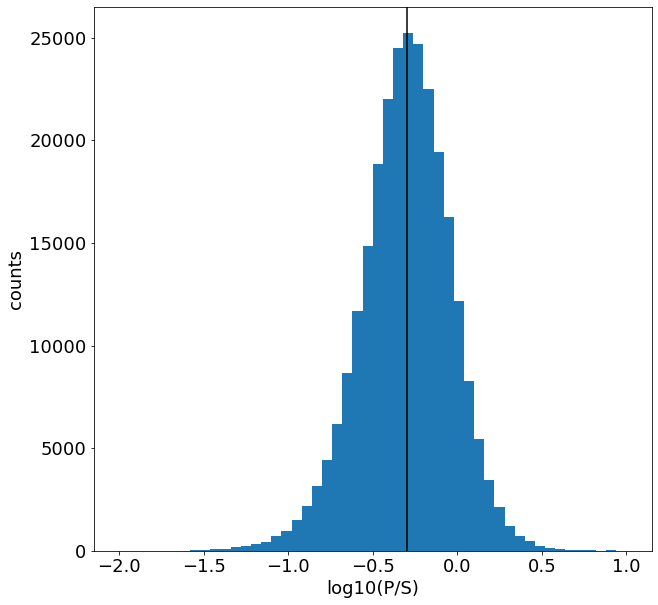

In [14]:
# Look at the distribution of P/S peak amplitude ratio
P_S_ratio = peak_amplitude_df.peak_P / peak_amplitude_df.peak_S
print(f'Median: {np.nanmedian(P_S_ratio)}')

fig, ax = plt.subplots(figsize=(10, 10))
ax.hist(np.log10(P_S_ratio), range=(-2, 1), bins=50)
ax.axvline(x=np.log10(np.nanmedian(P_S_ratio)), zorder=10, color='k')
ax.set_xlabel('log10(P/S)')
ax.set_ylabel('counts')
plt.savefig(results_output_dir + '/peak_strain_rate_P_S_ratio.png', bbox_inches='tight')

### Notes on the linear regression

```python
# Example of a linear fit using sklearn
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)
```

```python
# Example of a linear fit using statsmodels package
import statsmodels.api as sm
X = sm.add_constant(X) # If the intercept is needed
reg = sm.OLS(y, X).fit()
print(reg.summary())

parameters = reg.params()

y_predict = reg.predict(X)

# Using smf (a simpler way)
import statsmodels.formula.api as smf
peak_amplitude_df = peak_amplitude_df.dropna()

regP = smf.ols(formula='np.log10(peak_P) ~ magnitude + np.log10(distance_in_km)',
                 data=peak_amplitude_df).fit()

# With the site term. Here -1 is necessary to force the intercept to be 0
regP_2 = smf.ols(formula='np.log10(peak_P) ~ magnitude + np.log10(distance_in_km) + C(channel_id) - 1', data=peak_amplitude_df).fit()

```

Save and load the regression results using statsmodels

```python
import statsmodels.api as sm
# Save
model.save(regression_results_dir + "/regression_results.pickle")
# Load
model = sm.load(regression_results_dir + "/regression_results.pickle")
print(model.summary())
```

### Regression 1. Linear regression on the data point (this regression ignores the different site responses)

To fit a linear relation (a, b and c) of $M$ (magnitude), $log_{10}D$ (distance) to $log_{10}E$ (peak amplitude), the constant intercept $c$ includes all other contributions

$log_{10}(E) = aM + blog_{10}D + c$

In [16]:
import statsmodels.formula.api as smf
peak_amplitude_df = peak_amplitude_df.dropna()

regP_1 = smf.ols(formula='np.log10(peak_P) ~ magnitude + np.log10(distance_in_km)', data=peak_amplitude_df).fit()
regS_1 = smf.ols(formula='np.log10(peak_S) ~ magnitude + np.log10(distance_in_km)', data=peak_amplitude_df).fit()

print(regP_1.summary())
print('\n\n')
print(regS_1.summary())

regP_1.save(regression_results_dir + "/P_regression_all_events_no_site_terms.pickle")
regS_1.save(regression_results_dir + "/S_regression_all_events_no_site_terms.pickle")

                            OLS Regression Results                            
Dep. Variable:       np.log10(peak_P)   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                 2.015e+05
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:55:54   Log-Likelihood:                -43611.
No. Observations:              263803   AIC:                         8.723e+04
Df Residuals:                  263800   BIC:                         8.726e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [17]:
# make prediciton and compare with the measured
y_P_predict_1 = regP_1.predict(peak_amplitude_df)
y_S_predict_1 = regS_1.predict(peak_amplitude_df)

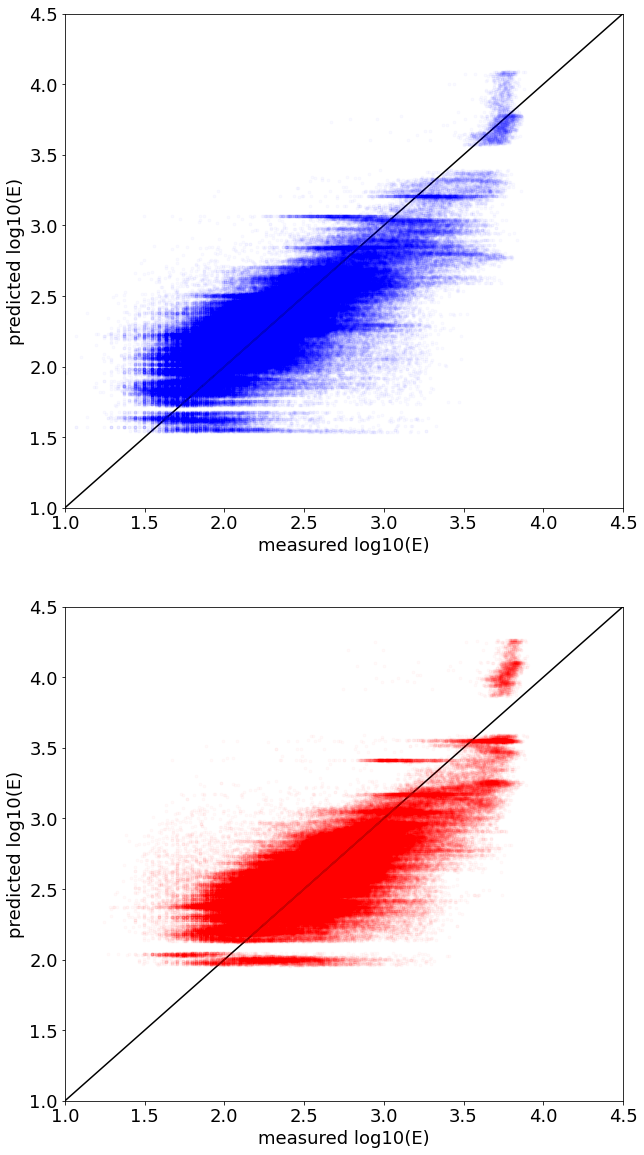

In [18]:
# Ground truth values
y_P = np.log10(peak_amplitude_df.peak_P)
y_S = np.log10(peak_amplitude_df.peak_S)

fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)

ax[0].plot([0, 10], [0, 10], '-k', zorder=1)
ax[0].plot(y_P, y_P_predict_1, 'b.', alpha=0.02)
ax[0].set_ylabel('predicted log10(E)')
ax[0].set_xlabel('measured log10(E)')
ax[0].xaxis.set_tick_params(which='both',labelbottom=True)

ax[1].plot([0, 10], [0, 10], '-k', zorder=1)
ax[1].plot(y_S, y_S_predict_1, 'r.', alpha=0.02)
ax[1].set_ylabel('predicted log10(E)')
ax[1].set_xlabel('measured log10(E)')

ax[1].set_xlim(1., 4.5)
ax[1].set_ylim(1., 4.5)

plt.savefig(regression_results_dir + '/validate_predicted_strain_rate_all_events_no_site_terms.png', bbox_inches='tight')

### Regression 2: Linear regression on the data point including the site term

To fit a linear relation (a, b and $K_s$) of $M$ (magnitude), $log_{10}D$ (distance) to $log_{10}E$ (peak amplitude), $K_s$ is a channel specific term to be fitted. Subscript $s$ here corresponds to $s^{th}$ channel.

So now there are in total (2 + # of channels) parameters to fit. 

$log_{10}(E_s) = aM + blog_{10}D + K_s$

In [19]:
regP_2 = smf.ols(formula='np.log10(peak_P) ~ magnitude + np.log10(distance_in_km) + C(channel_id) - 1', data=peak_amplitude_df).fit()
regS_2 = smf.ols(formula='np.log10(peak_S) ~ magnitude + np.log10(distance_in_km) + C(channel_id) - 1', data=peak_amplitude_df).fit()

print(regP_2.params[-2:])
print('\n\n')
print(regS_2.params[-2:])

regP_2.save(regression_results_dir + "/P_regression_all_events_with_site_terms.pickle")
regS_2.save(regression_results_dir + "/S_regression_all_events_with_site_terms.pickle")

magnitude                   0.648176
np.log10(distance_in_km)   -1.491775
dtype: float64



magnitude                   0.672528
np.log10(distance_in_km)   -1.200575
dtype: float64


In [20]:
# make prediciton and compare with the measured
y_P_predict_2 = regP_2.predict(peak_amplitude_df)
y_S_predict_2 = regS_2.predict(peak_amplitude_df)

### First check the fitted site responses

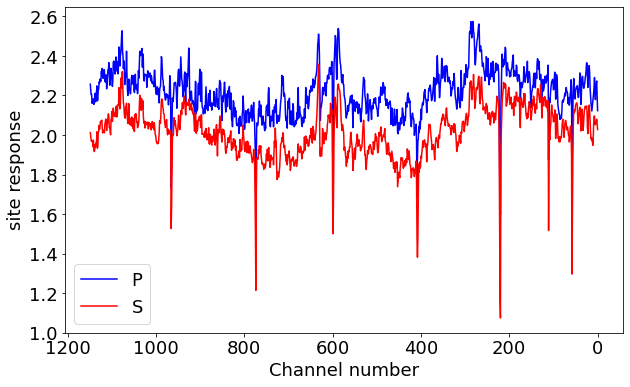

In [21]:
fig, ax = plt.subplots(figsize=(10, 6), sharex=True)
ax.plot(np.array(regP_2.params[:-2]), 'b', label='P')
ax.plot(np.array(regS_2.params[:-2]), 'r', label='S')

ax.invert_xaxis()
#ax.set_ylim(1, 4)
ax.legend()
ax.set_xlabel('Channel number')
ax.set_ylabel('site response')
plt.savefig(regression_results_dir + '/all_events_site_terms.png', bbox_inches='tight')

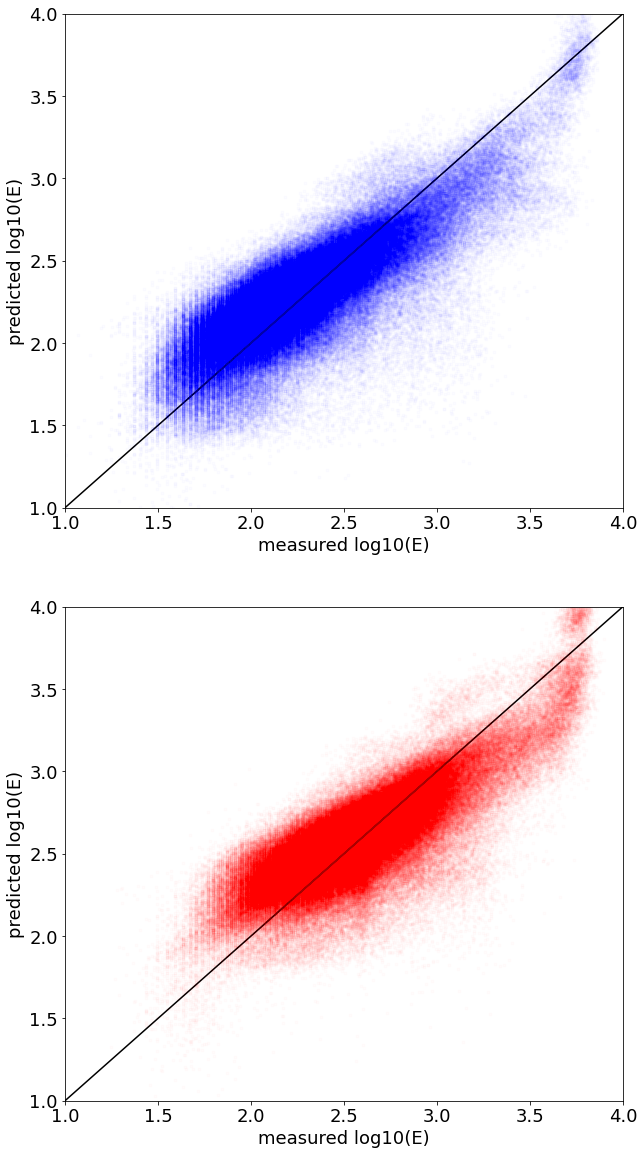

In [22]:
# Ground truth values
y_P = np.log10(peak_amplitude_df.peak_P)
y_S = np.log10(peak_amplitude_df.peak_S)


fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)

ax[0].plot([0, 10], [0, 10], '-k', zorder=1)
ax[0].plot(y_P, y_P_predict_2, 'b.', alpha=0.01)
ax[0].set_ylabel('predicted log10(E)')
ax[0].set_xlabel('measured log10(E)')
ax[0].xaxis.set_tick_params(which='both',labelbottom=True)

ax[1].plot([0, 10], [0, 10], '-k', zorder=1)
ax[1].plot(y_S, y_S_predict_2, 'r.', alpha=0.01)
ax[1].set_ylabel('predicted log10(E)')
ax[1].set_xlabel('measured log10(E)')

ax[1].set_xlim(1., 4)
ax[1].set_ylim(1., 4)
plt.savefig(regression_results_dir + '/validate_predicted_strain_rate_all_events_with_site_terms.png', bbox_inches='tight')

# A series of tests

## TEST1. Using small events (M3-M4) to fit the relation, then use the fitted relation to predict magnitude for M4+ earthquakes 

In [23]:
# Load the peak amplitude results
das_pick_file_name = results_output_dir + '/peak_amplitude_M3+.csv'
peak_amplitude_df = pd.read_csv(das_pick_file_name)
peak_amplitude_df

,Unnamed: 0,event_id,magnitude,distance_in_km,peak_P,peak_S,channel_id
0,0,38522647.0,4.17,13.325344,2845.676270,6852.172363,25.0
1,1,38522647.0,4.17,13.323814,2525.390625,5682.281250,26.0
2,2,38522647.0,4.17,13.322380,2594.920898,5590.161133,27.0
3,3,38522647.0,4.17,13.320950,2537.780762,6123.412598,28.0
4,4,38522647.0,4.17,13.319525,3586.303467,5624.999512,29.0
...,...,...,...,...,...,...,...
263798,265645,39659271.0,3.59,54.072423,124.999992,214.843735,1245.0
263799,265646,39659271.0,3.59,54.078379,134.765625,236.328110,1246.0
263800,265647,39659271.0,3.59,54.084403,101.562492,247.070297,1247.0
263801,265648,39659271.0,3.59,54.090361,100.463860,253.784164,1248.0


### 1) Split the data into two parts: m3 is used to fit the relation, m4 is used to test the prediction

In [24]:
peak_amplitude_df_m3 = peak_amplitude_df[peak_amplitude_df['magnitude'] <= 4]
peak_amplitude_df_m4 = peak_amplitude_df[peak_amplitude_df['magnitude'] > 4]

In [25]:
peak_amplitude_df_m3.to_csv(results_output_dir + '/peak_amplitude_M3.csv', index=False) 
peak_amplitude_df_m4.to_csv(results_output_dir + '/peak_amplitude_M4.csv', index=False)

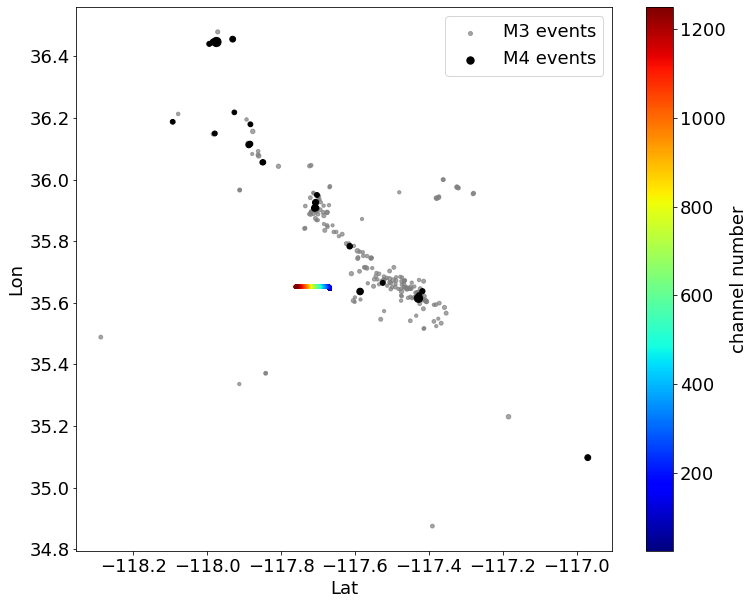

In [26]:
# Show the selected earthquakes
event_id_m3 = np.unique(peak_amplitude_df_m3['event_id'])
catalog_m3 = catalog[catalog[0].isin(event_id_m3)]

event_id_m4 = np.unique(peak_amplitude_df_m4['event_id'])
catalog_m4 = catalog[catalog[0].isin(event_id_m4)]

fig, ax = plt.subplots(figsize=(12, 10))
cmp = ax.scatter(DAS_lon, DAS_lat, s=10, c=DAS_index, cmap='jet')
ax.scatter(catalog_m3[5], catalog_m3[4], s=10**(catalog_m3[7]/3), c='gray', alpha=0.7, label='M3 events')
ax.scatter(catalog_m4[5], catalog_m4[4], s=10**(catalog_m4[7]/3), c='k', label='M4 events')
fig.colorbar(cmp, label='channel number')

ax.legend()
ax.set_xlabel('Lat')
ax.set_ylabel('Lon')
plt.savefig(results_output_dir + '/map_of_earthquakes_grouped.png', bbox_inches='tight')

### 2a) Fit the relation using M3 events WITHOUT site terms

In [27]:
import statsmodels.formula.api as smf
peak_amplitude_df = peak_amplitude_df.dropna()

regP_m3_without_site = smf.ols(formula='np.log10(peak_P) ~ magnitude + np.log10(distance_in_km)', data=peak_amplitude_df_m3).fit()
regS_m3_without_site = smf.ols(formula='np.log10(peak_S) ~ magnitude + np.log10(distance_in_km)', data=peak_amplitude_df_m3).fit()

print(regP_m3_without_site.summary())
print('\n\n')
print(regS_m3_without_site.summary())

regP_m3_without_site.save(regression_results_dir + "/P_regression_m3_events_without_site_terms.pickle")
regS_m3_without_site.save(regression_results_dir + "/S_regression_m3_events_without_site_terms.pickle")

                            OLS Regression Results                            
Dep. Variable:       np.log10(peak_P)   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                 1.382e+05
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:58:38   Log-Likelihood:                -39363.
No. Observations:              237388   AIC:                         7.873e+04
Df Residuals:                  237385   BIC:                         7.876e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### 2b) Fit the relation using M3 events WITH site terms

In [28]:
regP_m3_with_site = smf.ols(formula='np.log10(peak_P) ~ magnitude + np.log10(distance_in_km) + C(channel_id) - 1', data=peak_amplitude_df_m3).fit()
regS_m3_with_site = smf.ols(formula='np.log10(peak_S) ~ magnitude + np.log10(distance_in_km) + C(channel_id) - 1', data=peak_amplitude_df_m3).fit()

print(regP_m3_with_site.params[-2:])
print('\n\n')
print(regS_m3_with_site.params[-2:])

regP_m3_with_site.save(regression_results_dir + "/P_regression_m3_events_with_site_terms.pickle")
regS_m3_with_site.save(regression_results_dir + "/S_regression_m3_events_with_site_terms.pickle")

magnitude                   0.669988
np.log10(distance_in_km)   -1.497264
dtype: float64



magnitude                   0.740846
np.log10(distance_in_km)   -1.208016
dtype: float64


In [29]:
print(regP_m3_with_site.summary())

                            OLS Regression Results                            
Dep. Variable:       np.log10(peak_P)   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     330.4
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:00:03   Log-Likelihood:                -17134.
No. Observations:              237388   AIC:                         3.657e+04
Df Residuals:                  236236   BIC:                         4.853e+04
Df Model:                        1151                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(channel_id)[25.0]     

In [30]:
print(regS_m3_with_site.summary())

                            OLS Regression Results                            
Dep. Variable:       np.log10(peak_S)   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     285.9
Date:                Wed, 16 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:00:04   Log-Likelihood:                -13938.
No. Observations:              237388   AIC:                         3.018e+04
Df Residuals:                  236236   BIC:                         4.213e+04
Df Model:                        1151                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
C(channel_id)[25.0]     

### 3) Apply the M3 relation to M4 events. This part is only for validation purpose!
### (M3, D3) -> f_M3(...) -> E_M3_predicted -> compare with the True E_M3

### (M4, D4) -> f_M3(...) -> E_M4_predicted -> compare with the True E_M4 (These data is NOT used to fit the relation)

In [31]:
# M3 strain prediction using M3 relation without site
y_P_m3_predict_without_site = regP_m3_without_site.predict(peak_amplitude_df_m3)
y_S_m3_predict_without_site = regS_m3_without_site.predict(peak_amplitude_df_m3)

# M4 strain prediction using M3 relation without site
y_P_m4_predict_without_site = regP_m3_without_site.predict(peak_amplitude_df_m4)
y_S_m4_predict_without_site = regS_m3_without_site.predict(peak_amplitude_df_m4)


# M3 strain prediction using M3 relation with site
y_P_m3_predict_with_site = regP_m3_with_site.predict(peak_amplitude_df_m3)
y_S_m3_predict_with_site = regS_m3_with_site.predict(peak_amplitude_df_m3)

# M4 strain prediction using M3 relation with site
y_P_m4_predict_with_site = regP_m3_with_site.predict(peak_amplitude_df_m4)
y_S_m4_predict_with_site = regS_m3_with_site.predict(peak_amplitude_df_m4)

In [32]:
# Prepare the true values
y_P_m3 = np.log10(peak_amplitude_df_m3.peak_P)
y_S_m3 = np.log10(peak_amplitude_df_m3.peak_S)
y_P_m4 = np.log10(peak_amplitude_df_m4.peak_P)
y_S_m4 = np.log10(peak_amplitude_df_m4.peak_S)

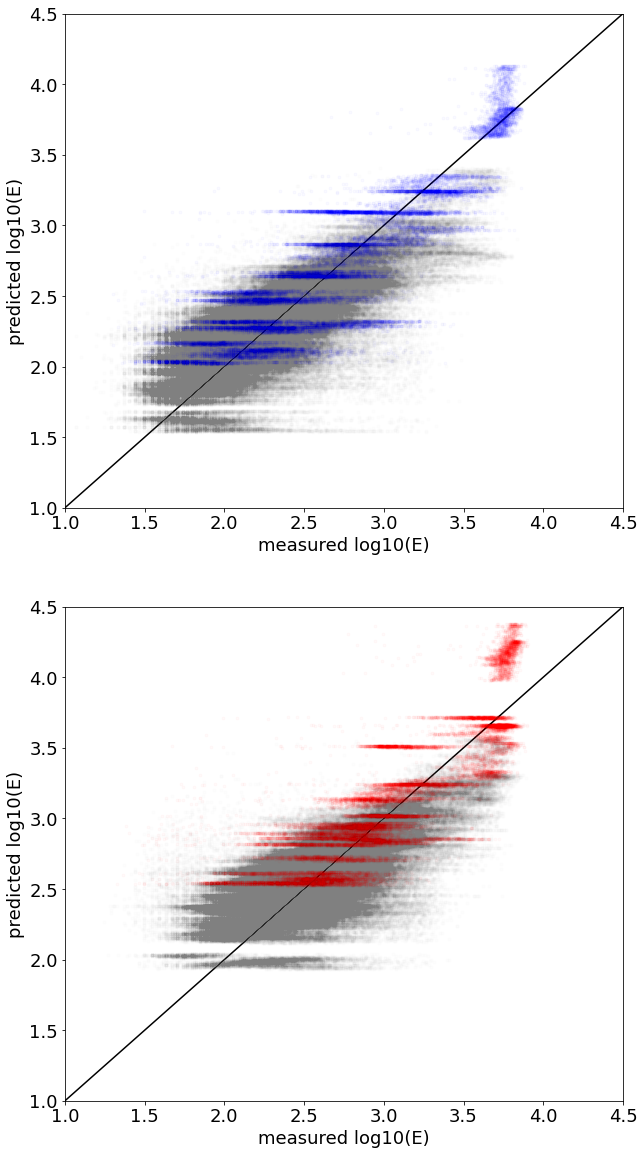

In [33]:
# Show validation results without site terms
fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)

ax[0].plot([0, 10], [0, 10], '-k', zorder=1)
ax[0].plot(y_P_m3, y_P_m3_predict_without_site, '.', color='gray', alpha=0.01)
ax[0].plot(y_P_m4, y_P_m4_predict_without_site, 'b.', alpha=0.02)
ax[0].set_ylabel('predicted log10(E)')
ax[0].set_xlabel('measured log10(E)')
ax[0].xaxis.set_tick_params(which='both',labelbottom=True)

ax[1].plot([0, 10], [0, 10], '-k', zorder=1)
ax[1].plot(y_S_m3, y_S_m3_predict_without_site, '.', color='gray', alpha=0.01)
ax[1].plot(y_S_m4, y_S_m4_predict_without_site, 'r.', alpha=0.02)
ax[1].set_ylabel('predicted log10(E)')
ax[1].set_xlabel('measured log10(E)')

ax[1].set_xlim(1., 4.5)
ax[1].set_ylim(1., 4.5)
plt.savefig(regression_results_dir + '/validate_predicted_strain_rate_m3_events_without_site_terms.png', bbox_inches='tight')

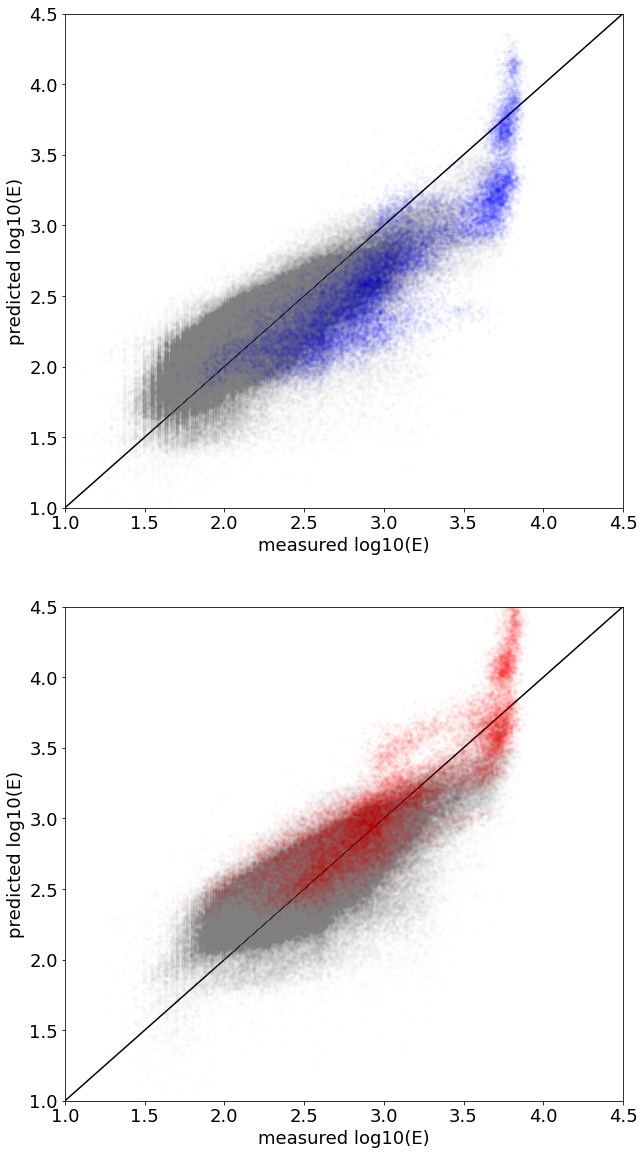

In [34]:
# Show validation results without site terms
fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)

ax[0].plot([0, 10], [0, 10], '-k', zorder=1)
ax[0].plot(y_P_m3, y_P_m3_predict_with_site, '.', color='gray', alpha=0.01)
ax[0].plot(y_S_m4, y_P_m4_predict_with_site, 'b.', alpha=0.02)
ax[0].set_ylabel('predicted log10(E)')
ax[0].set_xlabel('measured log10(E)')
ax[0].xaxis.set_tick_params(which='both',labelbottom=True)

ax[1].plot([0, 10], [0, 10], '-k', zorder=1)
ax[1].plot(y_S_m3, y_S_m3_predict_with_site, '.', color='gray', alpha=0.01)
ax[1].plot(y_S_m4, y_S_m4_predict_with_site, 'r.', alpha=0.02)
ax[1].set_ylabel('predicted log10(E)')
ax[1].set_xlabel('measured log10(E)')

ax[1].set_xlim(1., 4.5)
ax[1].set_ylim(1., 4.5)
plt.savefig(regression_results_dir + '/validate_predicted_strain_rate_m3_events_with_site_terms.png', bbox_inches='tight')

### 4) Now use the fitted relation to calculate the magnitude from measured strain (this is to test the PREDICTION ABLILITY of the fitted relation)

### $log_{10}(E_s) = aM + blog_{10}D + K_s$  =>  $M = [log_{10}(E_s) - blog_{10}D - c]/a$

### $log_{10}(E_s) = aM + blog_{10}D + K_s$  =>  $M = [log_{10}(E_s) - blog_{10}D - K_s]/a$

In [35]:
# Use the predicted strain to calculate magnitude
def calculate_magnitude_from_strain(peak_amplitude_df, reg, fitting_type='without_site'):
    
    if fitting_type == 'with_site':
        # get the annoying categorical keys
        channel_keys = np.array([f'C(channel_id)[{channel_id:.1f}]' for channel_id in peak_amplitude_df.channel_id])
        M_predict = (np.log10(peak_amplitude_df.peak_P) \
                    - np.array(reg.params[channel_keys]) \
                    - reg.params['np.log10(distance_in_km)'] * np.log10(peak_amplitude_df.distance_in_km)) \
                    / reg.params['magnitude']
        
    elif fitting_type == 'without_site':
        M_predict = (np.log10(peak_amplitude_df.peak_P) \
                    - reg.params['Intercept'] \
                    - reg.params['np.log10(distance_in_km)'] * np.log10(peak_amplitude_df.distance_in_km)) \
                    / reg.params['magnitude']
    else:
        raise NameError('Fitting type is undefined!')
        
    return M_predict

def get_mean_magnitude(peak_amplitude_df, M_predict):
    temp_df = peak_amplitude_df[['event_id', 'magnitude']].copy()
    temp_df['predicted_M'] = M_predict
    temp_df = temp_df.groupby(temp_df['event_id']).aggregate('mean')
    return temp_df

### Use the regression relation from M3 earthquakes to extrapolate to M4

### First do extrapolation for regression WITHOUT site terms

In [36]:
# First estimate the magnitude using the regression without site terms
M3_predict_P_without_site = calculate_magnitude_from_strain(peak_amplitude_df_m3, regP_m3_without_site, fitting_type='without_site')
M3_predict_S_without_site = calculate_magnitude_from_strain(peak_amplitude_df_m3, regS_m3_without_site, fitting_type='without_site')

mean_M3_P_without_site = get_mean_magnitude(peak_amplitude_df_m3, M3_predict_P_without_site)
mean_M3_S_without_site = get_mean_magnitude(peak_amplitude_df_m3, M3_predict_S_without_site)

In [37]:
# Also extrapolate to M4 earthquakes
M4_predict_P_without_site = calculate_magnitude_from_strain(peak_amplitude_df_m4, regP_m3_without_site, fitting_type='without_site')
M4_predict_S_without_site = calculate_magnitude_from_strain(peak_amplitude_df_m4, regS_m3_without_site, fitting_type='without_site')

mean_M4_P_without_site = get_mean_magnitude(peak_amplitude_df_m4, M4_predict_P_without_site)
mean_M4_S_without_site = get_mean_magnitude(peak_amplitude_df_m4, M4_predict_S_without_site)

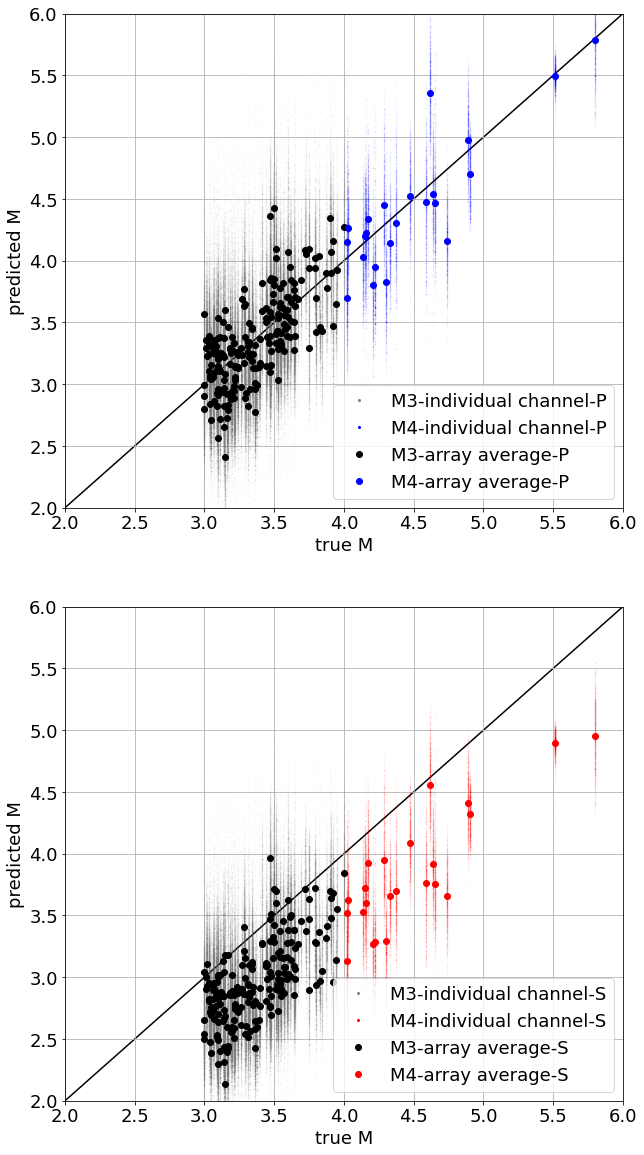

In [38]:
fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)

ax[0].plot([0, 10], [0, 10], '-k', zorder=1)
# magnitude from individual channel
ax[0].plot(peak_amplitude_df_m3.magnitude, M3_predict_P_without_site, 'o', color='gray', alpha=0.02, markersize=1)
ax[0].plot(peak_amplitude_df_m4.magnitude, M4_predict_P_without_site, 'bo', alpha=0.02, markersize=1)
# a ghost one for legend
ax[0].plot(np.nan, np.nan, 'o', color='gray', alpha=1, markersize=2, label='M3-individual channel-P') 
ax[0].plot(np.nan, np.nan, 'bo', alpha=1, markersize=2, label='M4-individual channel-P') 

# Mean magntitude from the entire DAS array
ax[0].plot(mean_M3_P_without_site.magnitude, mean_M3_P_without_site.predicted_M, 'o', color='k', alpha=1, label='M3-array average-P')
ax[0].plot(mean_M4_P_without_site.magnitude, mean_M4_P_without_site.predicted_M, 'bo', alpha=1, label='M4-array average-P')
ax[0].set_ylabel('predicted M')
ax[0].set_xlabel('true M')
ax[0].xaxis.set_tick_params(which='both',labelbottom=True)
ax[0].legend(loc=4)
ax[0].grid()



ax[1].plot([0, 10], [0, 10], '-k', zorder=1)
# magnitude from individual channel
ax[1].plot(peak_amplitude_df_m3.magnitude, M3_predict_S_without_site, 'o', color='gray', alpha=0.02, markersize=1)
ax[1].plot(peak_amplitude_df_m4.magnitude, M4_predict_S_without_site, 'ro', alpha=0.02, markersize=1)
# a ghost one for legend
ax[1].plot(np.nan, np.nan, 'o', color='gray', alpha=1, markersize=2, label='M3-individual channel-S') 
ax[1].plot(np.nan, np.nan, 'ro', alpha=1, markersize=2, label='M4-individual channel-S') 

# Mean magntitude from the entire DAS array
ax[1].plot(mean_M3_S_without_site.magnitude, mean_M3_S_without_site.predicted_M, 'o', color='k', alpha=1, label='M3-array average-S')
ax[1].plot(mean_M4_S_without_site.magnitude, mean_M4_S_without_site.predicted_M, 'ro', alpha=1, label='M4-array average-S')
ax[1].set_ylabel('predicted M')
ax[1].set_xlabel('true M')
ax[1].legend(loc=4)
ax[1].grid()

ax[1].set_xlim(2, 6)
ax[1].set_ylim(2, 6)
plt.savefig(regression_results_dir + '/predict_M4_magnitude_from_M3_regression_without_site.png', bbox_inches='tight')

### Then do extrapolation for regression WITH site terms

In [39]:
# First estimate the magnitude using the regression WITH site terms
M3_predict_P_with_site = calculate_magnitude_from_strain(peak_amplitude_df_m3, regP_m3_with_site, fitting_type='with_site')
M3_predict_S_with_site = calculate_magnitude_from_strain(peak_amplitude_df_m3, regS_m3_with_site, fitting_type='with_site')

mean_M3_P_with_site = get_mean_magnitude(peak_amplitude_df_m3, M3_predict_P_with_site)
mean_M3_S_with_site = get_mean_magnitude(peak_amplitude_df_m3, M3_predict_S_with_site)

In [40]:
# Also extrapolate to M4 earthquakes
M4_predict_P_with_site = calculate_magnitude_from_strain(peak_amplitude_df_m4, regP_m3_with_site, fitting_type='with_site')
M4_predict_S_with_site = calculate_magnitude_from_strain(peak_amplitude_df_m4, regS_m3_with_site, fitting_type='with_site')

mean_M4_P_with_site = get_mean_magnitude(peak_amplitude_df_m4, M4_predict_P_with_site)
mean_M4_S_with_site = get_mean_magnitude(peak_amplitude_df_m4, M4_predict_S_with_site)

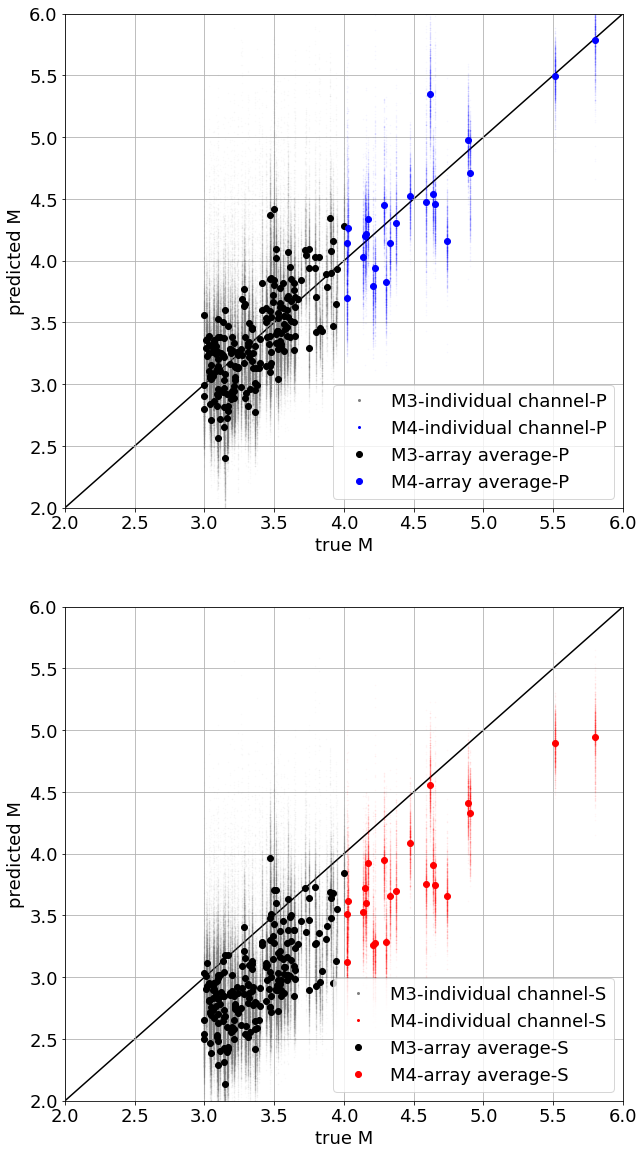

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)

ax[0].plot([0, 10], [0, 10], '-k', zorder=1)
# magnitude from individual channel
ax[0].plot(peak_amplitude_df_m3.magnitude, M3_predict_P_with_site, 'o', color='gray', alpha=0.02, markersize=1)
ax[0].plot(peak_amplitude_df_m4.magnitude, M4_predict_P_with_site, 'bo', alpha=0.02, markersize=1)
# a ghost one for legend
ax[0].plot(np.nan, np.nan, 'o', color='gray', alpha=1, markersize=2, label='M3-individual channel-P') 
ax[0].plot(np.nan, np.nan, 'bo', alpha=1, markersize=2, label='M4-individual channel-P') 

# Mean magntitude from the entire DAS array
ax[0].plot(mean_M3_P_with_site.magnitude, mean_M3_P_with_site.predicted_M, 'o', color='k', alpha=1, label='M3-array average-P')
ax[0].plot(mean_M4_P_with_site.magnitude, mean_M4_P_with_site.predicted_M, 'bo', alpha=1, label='M4-array average-P')
ax[0].set_ylabel('predicted M')
ax[0].set_xlabel('true M')
ax[0].xaxis.set_tick_params(which='both',labelbottom=True)
ax[0].legend(loc=4)
ax[0].grid()



ax[1].plot([0, 10], [0, 10], '-k', zorder=1)
# magnitude from individual channel
ax[1].plot(peak_amplitude_df_m3.magnitude, M3_predict_S_with_site, 'o', color='gray', alpha=0.02, markersize=1)
ax[1].plot(peak_amplitude_df_m4.magnitude, M4_predict_S_with_site, 'ro', alpha=0.02, markersize=1)
# a ghost one for legend
ax[1].plot(np.nan, np.nan, 'o', color='gray', alpha=1, markersize=2, label='M3-individual channel-S') 
ax[1].plot(np.nan, np.nan, 'ro', alpha=1, markersize=2, label='M4-individual channel-S') 

# Mean magntitude from the entire DAS array
ax[1].plot(mean_M3_S_with_site.magnitude, mean_M3_S_with_site.predicted_M, 'o', color='k', alpha=1, label='M3-array average-S')
ax[1].plot(mean_M4_S_with_site.magnitude, mean_M4_S_with_site.predicted_M, 'ro', alpha=1, label='M4-array average-S')
ax[1].set_ylabel('predicted M')
ax[1].set_xlabel('true M')
ax[1].legend(loc=4)
ax[1].grid()

ax[1].set_xlim(2, 6)
ax[1].set_ylim(2, 6)
plt.savefig(regression_results_dir + '/predict_M4_magnitude_from_M3_regression_with_site.png', bbox_inches='tight')

### Comparing the parameters of regression for different types of fittings

In [42]:
mean_M3_P_with_site.shape[0]

207

In [43]:
num_events_m3, num_events_m4 = mean_M3_P_with_site.shape[0], mean_M4_P_with_site.shape[0]
print(f'number of M3 events: {num_events_m3}')
print(f'number of M4 events: {num_events_m4}')

number of M3 events: 207
number of M4 events: 23


In [44]:
regP_1.params[-2:], regP_2.params[-2:], regP_m3_without_site.params[-2:], regP_m3_with_site.params[-2:]

(magnitude                   0.649370
 np.log10(distance_in_km)   -1.499446
 dtype: float64,
 magnitude                   0.648176
 np.log10(distance_in_km)   -1.491775
 dtype: float64,
 magnitude                   0.671249
 np.log10(distance_in_km)   -1.506163
 dtype: float64,
 magnitude                   0.669988
 np.log10(distance_in_km)   -1.497264
 dtype: float64)

In [45]:
regS_1.params[-2:], regS_2.params[-2:], regS_m3_without_site.params[-2:], regS_m3_with_site.params[-2:]

(magnitude                   0.674436
 np.log10(distance_in_km)   -1.213031
 dtype: float64,
 magnitude                   0.672528
 np.log10(distance_in_km)   -1.200575
 dtype: float64,
 magnitude                   0.742761
 np.log10(distance_in_km)   -1.221598
 dtype: float64,
 magnitude                   0.740846
 np.log10(distance_in_km)   -1.208016
 dtype: float64)

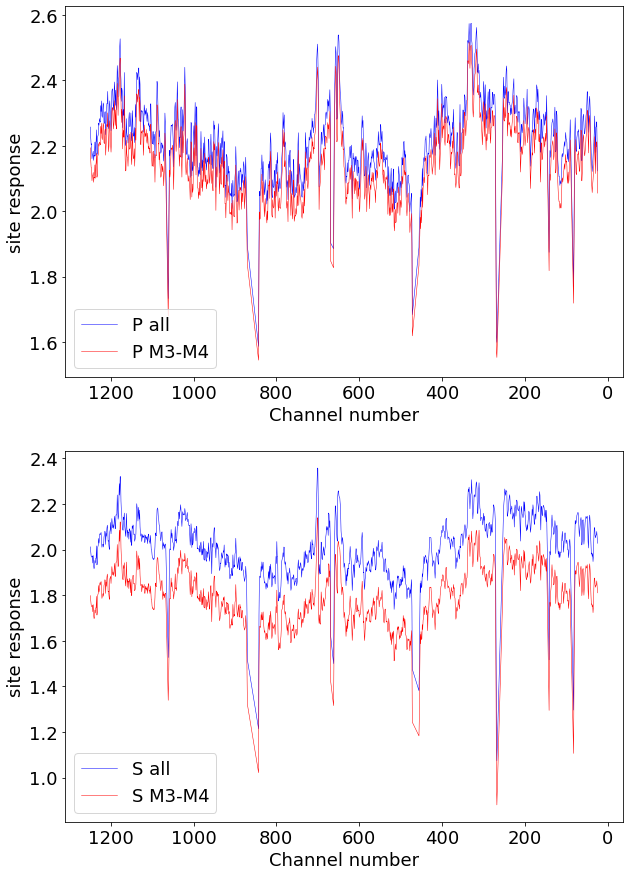

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(10, 15), sharex=True)
ax[0].plot(DAS_index, regP_2.params[:-2], 'b', label='P all', linewidth=0.5)
ax[0].plot(DAS_index, regP_m3_with_site.params[:-2], 'r', label='P M3-M4', linewidth=0.5)
ax[0].xaxis.set_tick_params(which='both',labelbottom=True)

ax[0].invert_xaxis()
ax[0].legend()
ax[0].set_ylabel('site response')
ax[0].set_xlabel('Channel number')


ax[1].plot(DAS_index, regS_2.params[:-2], 'b', label='S all', linewidth=0.5)
ax[1].plot(DAS_index, regS_m3_with_site.params[:-2], 'r', label='S M3-M4', linewidth=0.5)

ax[1].legend()
ax[1].set_xlabel('Channel number')
ax[1].set_ylabel('site response')
plt.savefig(regression_results_dir + '/site_terms_comparisons.png', bbox_inches='tight')

# DOESN'T WORK BELOW:

### Instead of fitting the peak amplitude, try to fit the magnitude. This will be a test for whether das amplitude can be used to predict the earthquake magnitude.

### Regression 1. Linear regression on the data point using sklearn (this regression ignores the different site responses)

To fit a linear relation (a', b' and c') of $log_{10}E$ (peak amplitude), $log_{10}D$ (distance) to $M$ (magnitude), the constant intercept $c'$ includes all other contributions

$M = c' + a'log_{10}(E) + b'log_{10}D$

In [ ]:
import statsmodels.api as sm

def remove_nan_magnitude_fit(X, y):
    '''Remove the nan in X for X and y'''
    ii_nan = np.isnan(X[:, 0]).flatten()
    return X[~ii_nan, :], y[~ii_nan]

def fit_magnitude_without_site(X_P, X_S, y_M):
    '''Fit the peak strain with site-response term'''
    
    # remove the nan in picked strain Y_P and y_S
    X_P, y_MP = remove_nan_magnitude_fit(X_P, y_M)
    X_S, y_MS = remove_nan_magnitude_fit(X_S, y_M)
    

    X_P = sm.add_constant(X_P)
    X_S = sm.add_constant(X_S)
    
    regP = sm.OLS(y_MP, X_P).fit()
    regS = sm.OLS(y_MS, X_S).fit()
    
    return X_P, X_S, y_MP, y_MS, regP, regS

def add_site_term(X, DAS_channel_num, num_events):
    ''' Add the diagnal terms to include site response term'''
    X = np.concatenate((X, np.repeat(np.eye(DAS_channel_num), num_events, axis=0)), axis=1)
    return X

def fit_magnitude_with_site(X_P, X_S, y_M, DAS_channel_num, num_events):
    '''Fit the peak strain with site-response term'''
    
    # Include the site terms using the diagnal matrices
    X_P = add_site_term(X_P, DAS_channel_num, num_events)
    X_S = add_site_term(X_S, DAS_channel_num, num_events)

    # remove the nan in picked strain Y_P and y_S
    X_P, y_MP = remove_nan_magnitude_fit(X_P, y_M)
    X_S, y_MS = remove_nan_magnitude_fit(X_S, y_M)
    
    regP = sm.OLS(y_MP, X_P).fit()
    regS = sm.OLS(y_MS, X_S).fit()
    
    return X_P, X_S, y_MP, y_MS, regP, regS


In [ ]:
# Fit magnitude without site
X_P = np.concatenate((np.log10(peak_ampliutde_P_all_flatten[:, np.newaxis]), np.log10(distance_all_km_flatten[:, np.newaxis])), axis=1)
X_S = np.concatenate((np.log10(peak_ampliutde_S_all_flatten[:, np.newaxis]), np.log10(distance_all_km_flatten[:, np.newaxis])), axis=1)

y_M = magnitude_all_flatten[:, np.newaxis]



X_MP1, X_MS1, y_MP, y_MS, regP_M1, regS_M1 = fit_magnitude_without_site(X_P, X_S, y_M)

print(regP_M1.summary())
print('\n\n')
print(regS_M1.summary())

In [ ]:
# make prediciton and compare with the measured
y_MP_predict_1 = regP_M1.predict(X_MP)
y_MS_predict_1 = regS_M1.predict(X_MS)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)

ax[0].plot([0, 10], [0, 10], '-k', zorder=1)
ax[0].plot(y_MP, y_MP_predict_1, 'b.', alpha=0.02)
ax[0].set_ylabel('predicted magnitude')

ax[1].plot([0, 10], [0, 10], '-k', zorder=1)
ax[1].plot(y_MS, y_MS_predict_1, 'r.', alpha=0.02)
ax[1].set_ylabel('predicted magnitude')
ax[1].set_xlabel('catalog magnitude')

ax[1].set_xlim(0, 5.)
ax[1].set_ylim(0, 5.)

### Regression 2: Linear regression on the data point using sklearn including the site term

To fit a linear relation (a', b' and $K_s'$) of $log_{10}E$ (peak amplitude), $log_{10}D$ (distance) to $M$ (magnitude), $K_s$ is a channel specific term to be fitted. Subscript $_s$ here corresponds to $s^{th}$ channel.

So now there are in total (2 + # of channels) parameters to fit. 

$M = a'log_{10}(E_s) + b'log_{10}D + K_s'$

In [ ]:
# Fit magnitude with site; Data (N_data x (2 + DAS_channel_num) features)
X_P = np.concatenate((np.log10(peak_ampliutde_P_all_flatten[:, np.newaxis]), np.log10(distance_all_km_flatten[:, np.newaxis])), axis=1)
X_S = np.concatenate((np.log10(peak_ampliutde_S_all_flatten[:, np.newaxis]), np.log10(distance_all_km_flatten[:, np.newaxis])), axis=1)

y_M = magnitude_all_flatten[:, np.newaxis]

X_MP2, X_MS2, y_MP, y_MS, regP_M2, regS_M2 = fit_magnitude_with_site(X_P, X_S, y_M, DAS_channel_num, num_events)

print(regP_M2.params[:2])
print('\n\n')
print(regS_M2.params[:2])

In [ ]:
# make prediciton and compare with the measured
y_MP_predict_2 = regP_M2.predict(X_MP2)
y_MS_predict_2 = regS_M2.predict(X_MS2)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)

ax[0].plot([0, 10], [0, 10], '-k', zorder=1)
ax[0].plot(y_MP, y_MP_predict_2, 'b.', alpha=0.01)
ax[0].set_ylabel('predicted magnitude')

ax[1].plot([0, 10], [0, 10], '-k', zorder=1)
ax[1].plot(y_MS, y_MS_predict_2, 'r.', alpha=0.01)
ax[1].set_ylabel('predicted magnitude')
ax[1].set_xlabel('catalog magnitude')

ax[1].set_xlim(0, 5.)
ax[1].set_ylim(0, 5.)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), sharex=True)
ax.plot(regP_M2.params[2:], 'b', label='P')
ax.plot(regS_M2.params[2:],'r', label='S')

ax.invert_xaxis()
ax.legend()
ax.set_xlabel('Channel number')
ax.set_ylabel('site response')

### Now, test the prediction ability of the magnitude by randomly choose part of the events

In [ ]:
def prepare_data(peak_amplitude_df):
    # Fitting results from M3-M3.5 earthquakes
    num_events = len(peak_amplitude_df['event_id'].unique())

    peak_ampliutde_P, peak_ampliutde_S, \
    distance, magnitude, event_id = extract_flatten_data(peak_amplitude_df)
    
    X_P = np.concatenate((np.log10(peak_ampliutde_P[:, np.newaxis]), np.log10(distance[:, np.newaxis])), axis=1)
    X_S = np.concatenate((np.log10(peak_ampliutde_S[:, np.newaxis]), np.log10(distance[:, np.newaxis])), axis=1)

    y_M = magnitude[:, np.newaxis]
   
    return X_P, X_S, y_M

def fit_magnitude_given_data(peak_amplitude_df):
    # Fitting results from M3-M3.5 earthquakes
    num_events = len(peak_amplitude_df['event_id'].unique())
   
    X_P, X_S, y_M = prepare_data(peak_amplitude_df)

    X_MP, X_MS, y_MP, y_MS, regP_M, regS_M = fit_magnitude_with_site(X_P, X_S, y_M, DAS_channel_num, num_events)

    return X_MP, X_MS, y_MP, y_MS, regP_M, regS_M

In [ ]:
# Load the peak amplitude results
output_file_name = '/kuafu/yinjx/Ridgecrest/Ridgecrest_strain_rate_scaling/peak_amplitude_M3+.csv'
peak_amplitude_df = pd.read_csv(output_file_name)

### separate the events into two groups: one is used to fit the relation (fit data set) and another one is used to test the prediction relation (prediction data set)

In [ ]:
event_id_unique = peak_amplitude_df['event_id'].unique()

In [ ]:
num_events = len(event_id_unique)
num_fit = int(0.8 * num_events)

In [ ]:
np.random.seed(111)
event_id_unique = np.random.permutation(event_id_unique)

event_id_fit = event_id_unique[:num_fit]
event_id_predict = event_id_unique[num_fit:]

In [ ]:
# split into different dataset, make sure to have the large events in the prediction set
ii_choose_event = (peak_amplitude_df['event_id'].isin(event_id_fit)) & (peak_amplitude_df['magnitude'] < 5)

peak_amplitude_df_fit = peak_amplitude_df[ii_choose_event]
peak_amplitude_df_predict = peak_amplitude_df[~ii_choose_event]

num_fit = len(peak_amplitude_df_fit['event_id'].unique())
num_predict = len(peak_amplitude_df_predict['event_id'].unique())

In [ ]:
X_MP_fit, X_MS_fit, y_MP_fit, y_MS_fit, regP_M_fit, regS_M_fit = fit_magnitude_given_data(peak_amplitude_df_fit)

In [ ]:
# Get the predicted magnitude for the data in the fit set
y_MP_fit_predict =regP_M_fit.predict(X_MP_fit)
y_MS_fit_predict =regS_M_fit.predict(X_MS_fit)

In [ ]:
# Reformat the X in the prediction set
X_MP_predict, X_MS_predict, y_M_predict_true = prepare_data(peak_amplitude_df_predict)
X_MP_predict = add_site_term(X_MP_predict, DAS_channel_num, num_predict)
X_MS_predict = add_site_term(X_MS_predict, DAS_channel_num, num_predict)

In [ ]:
y_MP_predict = regP_M_fit.predict(X_MP_predict)
y_MS_predict = regS_M_fit.predict(X_MS_predict)

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)

ax[0].plot([0, 10], [0, 10], '-k', zorder=1)
ax[0].plot(y_MP_fit, y_MP_fit_predict, '.', color='gray', alpha=0.01, zorder=-1)
ax[0].plot(y_M_predict_true, y_MP_predict, 'b.', alpha=0.5, zorder=0)
ax[0].set_ylabel('predicted magnitude')

ax[1].plot([0, 10], [0, 10], '-k', zorder=1)
ax[1].plot(y_MS_fit, y_MS_fit_predict, '.', color='gray', alpha=0.01, zorder=-1)
ax[1].plot(y_M_predict_true, y_MS_predict, 'r.', alpha=0.5, zorder=0)
ax[1].set_ylabel('predicted magnitude')
ax[1].set_xlabel('catalog magnitude')

ax[1].set_xlim(0, 6)
ax[1].set_ylim(0, 6)

In [ ]:
y_MP_predict1 = np.reshape(y_MP_predict, (num_predict, -1))
y_MS_predict1 = np.reshape(y_MS_predict, (num_predict, -1))
y_M_predict_true1 = np.reshape(y_M_predict_true, (num_predict, -1))

In [ ]:
y_MP_predict1.shape

In [ ]:
y_M_predict_true1.shape

In [ ]:
y_MP_predict1

In [ ]:
magnitude_predict_P = np.nanmean(y_MP_predict1, axis=1)
magnitude_predict_S = np.nanmean(y_MS_predict1, axis=1)
magnitude_true = np.nanmean(y_M_predict_true1, axis=1)

In [ ]:
catalog_file = './Ridgecrest_das_catalog_M2_M8.txt'
catalog = pd.read_csv(catalog_file, sep='\s+', header=None, skipfooter=1, engine='python')
magnitude_catalog = catalog[catalog[0].isin(event_id_predict)]
magnitude_catalog = np.array(magnitude_catalog[7])

In [ ]:
magnitude_catalog

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)

ax[0].plot([0, 10], [0, 10], '-k', zorder=1)
ax[0].plot(y_MP_fit, y_MP_fit_predict, '.', color='gray', alpha=0.01, zorder=-1)
ax[0].plot(magnitude_true, magnitude_predict_P, 'bo', alpha=1, zorder=0)
ax[0].set_ylabel('predicted magnitude')

ax[1].plot([0, 10], [0, 10], '-k', zorder=1)
ax[1].plot(y_MS_fit, y_MS_fit_predict, '.', color='gray', alpha=0.01, zorder=-1)
ax[1].plot(magnitude_true, magnitude_predict_S, 'ro', alpha=1, zorder=0)
ax[1].set_ylabel('predicted magnitude')
ax[1].set_xlabel('catalog magnitude')

ax[1].set_xlim(2.5, 6)
ax[1].set_ylim(2.5, 6)

In [ ]:
magnitude_catalog.shape

In [ ]:
magnitude_predict_P.shape